In [1]:
using Pkg; Pkg.activate(".")
# Pkg.instantiate()

using Random
using DataStructures
using PyPlot

  Activating project at `~/Projects/fire-grid`


In [2]:
# parameters
nd = 2 # dimensions
nx = 100

ntyear = 5 # growing-burning season
ntmature = ntyear * 10  # 10 years to maturity
ntignite = ntyear * 100 # lightning frequency every 100 years per grid
p_grow = 1/ntmature
p_ignite = 1/ntignite

0.002

In [10]:
# landscape functions

function interior(A)
    sz = size(A)
    nd = length(sz)
    CartesianIndices(ntuple(d -> 2:sz(d)-1, nd)) # interior indices, not used in periodic
end

"grow mature trees in empty cells with probability p"
function grow!(tree, sincetree, p=p_grow)
    # Loop through each CartesianIndex and grow trees in bare cells
    for I in findall(.!tree) # eachindex(tree)
        # Access or update the array using the CartesianIndex
        # if !tree[I]
            if rand() < p
                tree[I] = true
                sincetree[I] = 0 # zero step counter for tree
            end
        # end
    end
end

# "ignite cells that have trees with some probability"
# function ignite!(fire, tree, sincefire, p=p_ignite)
#     for I in findall(tree) # .&&.! fire
#         # Access or update the array using the CartesianIndex
#         if rand() < p
#             fire[I] = true
#             tree[I] = false
#             sincefire[I] = 0 # zero step counter for fire
#         end
#     end
# end

"ignite cells that have trees with some probability"
function ignite!(tree, sincefire, p=p_ignite)
    strike(tree) = tree && rand() < p # lightning strike probability
    ignites = findall(strike, tree) # find all cells that are ignited
    for I in ignites
        fire[I] = true
        tree[I] = false
        sincefire[I] = 0 # zero step counter for fire
    end
    return ignites
end

# burn functions
"CartesianIndex to shift s(=1) index in dimension dim"
offset(dim, nd=nd, s=1) = CartesianIndex(ntuple(j -> j==dim ? s : 0, nd))

"Periodic modifying shift index of dimension dim by s(=1)"
function shift(idx::CartesianIndex, offset::CartesianIndex, sz::NTuple{N, Int}) where N
    new_coord = ntuple(d -> mod1(idx[d] + offset[d], sz[d]), N) # N is number of dimensions
    CartesianIndex(new_coord)
end

"spread a single fire from a seed fire cell to all connected tree cells"
function spread1fire!(seed, tree, sincefire, sz)
    nd = length(sz)
    fire = falses(sz) # create a private fire grid for each ignition
    fire[seed] = true # ignite the seed cell
    print("^")
    # start with one seed cell
    firesize = 1 # initialize fire size as 1 for seed grid
    # add neighbors, extinguish old fire cells...repeat;
    # finish with no fire cells left
    while any(fire)
        for I in findall(fire) # propagate 1 strike to all connected trees
            for D in 1:nd # spread forward and backward in each dimension
                for ofs in offset.(D, nd, [-1, 1]) # on a periodic domain
                    neighbor = shift(I, ofs, sz)
                    if tree[neighbor] # burn cells if treed
                        fire[neighbor] = true   # propagate fire to neighbor
                        print(">")
                        tree[neighbor] = false  # burn trees
                        sincefire[neighbor] = 0 # zero step counter for fire
                        firesize += 1 # increment fire size as neighbors are added
                    end
                end
            end
            fire[I] = false # old fire cells burn out
        end
    end
    print(" $firesize\n")
    return firesize
end

"propagate all fires to their neighboring trees"
function burn!(tree, sincefire, firesizes::CircularBuffer{Int})
    sz = size(tree)
    fire = falses(sz) # create a private fire grid for each ignition
    ignites = ignite!(tree, sincefire) # lighting ignite some trees in the grid
    print("after ignite. trees: $(sum(tree)), fires: $(length(ignites))\n")
    for I in ignites # burn each ignition individually
        firesize = spread1fire!(I, tree, sincefire, sz)
        push!(firesizes, firesize)
    end
end

# old and works:
#=
"propagate fires to neighboring trees on a periodic domain"
function burn!(fire, tree, sincefire)
    sz = size(tree)
    nd = length(sz)
    ignite!(fire, tree, sincefire)
    # fire repeats search for neighbors, getting all neighboring trees
    while any(fire[:]) 
        for I in findall(fire) # propagate 1 strike to all connected trees
            firesize = 1 # count fire grids
            for D in 1:nd # spread forward and backward in each dimension
                for ofs in offset.(D, nd, [-1, 1])
                    target = shift(I, ofs, sz)
                    if tree[target] # burn cells if treed
                        fire[target] = true
                        tree[target] = false
                        sincefire[target] = 0 # zero step counter for fire
                        firesize += 1 # count fire grids
                    end
                end
            end
            fire[I] = false # original fire burns out
        end
    end
end
=#

"daily step"
function step!(tree, sincefire, sincetree, firesizes)
    grow!(tree, sincetree)
    print("after growth. trees: $(sum(tree))")
    # fires burn until all neighboring trees are gone
    burn!(tree, sincefire, firesizes)

    # increment age of all trees and time since fire
    sincetree[findall(tree)] .+= 1
    sincefire .+= 1
end

step!

In [46]:
# initialize
Random.seed!(42)

nx = 30
nd = 3
tree = falses(fill(nx, nd)...) # initialize array
sz = size(tree)
C = CartesianIndices(tree)
fire = falses(sz)

# diagnostics count days
# continuously incrementing, reset by events
sincetree = zeros(Int64, sz)
sincefire = zeros(Int64, sz)
nc = 1000 # number of fire sizes to keep in buffer
firesizes = CircularBuffer{Int}(nc) # buffer for fire sizes
append!(firesizes, zeros(nc)) # fill buffer with zeros

# single steps
step!(tree, sincefire, sincetree, firesizes)
step!(tree, sincefire, sincetree, firesizes)
sum(tree)

1062

In [48]:
# big run
nyear = 1000
ndays = nyear * ntyear

for i in 1:ndays
    step!(tree, sincefire, sincetree, firesizes)
end

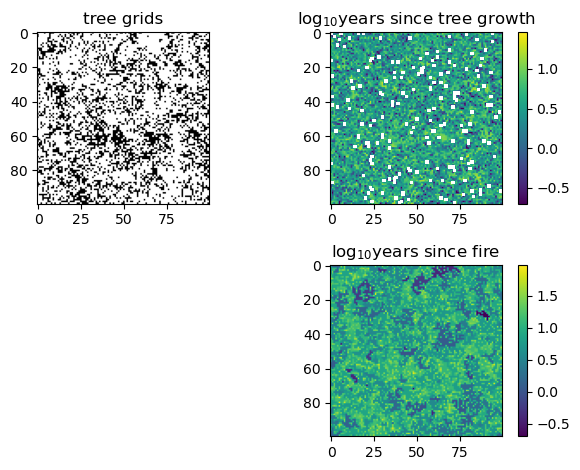

In [22]:
cm = PyPlot.cm

clf()
subplot(2,2,1)
imshow(tree, cmap=PyPlot.cm.Greys)
title("tree grids")

subplot(2,2,2)
imshow(log10.(sincetree/ntyear)); colorbar()
# blank spots have new age=0 trees
# imshow((sincetree/ntyear)); colorbar()
title("log\$_{10}\$years since tree growth")

subplot(2,2,4)
imshow(log10.(sincefire/ntyear)); colorbar()
title("log\$_{10}\$years since fire")
tight_layout()

savefig("grid_2d.png")
gcf()

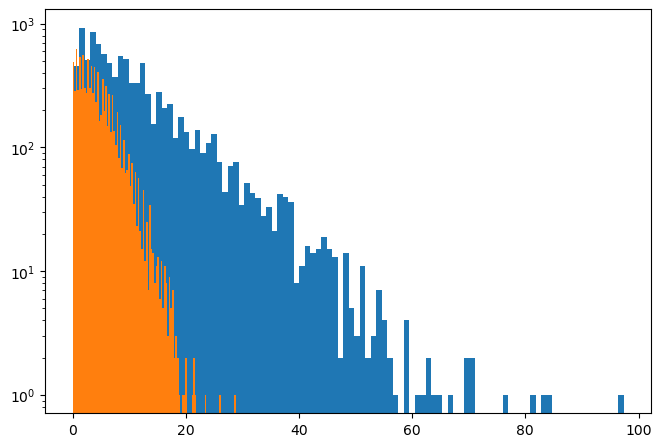

In [23]:
clf()
hist(sincefire[:]/ntyear, 100)
hist(sincetree[:]/ntyear, 100)
# plot([0, 8000], [5e3, 1.5])
# plot(0:100:8000, 5e3*exp.(-(0:100:8000)./988))
yscale("log")
gcf()
# slope is a factor of 5 per 2000 days
# 5e3 / 8000 days

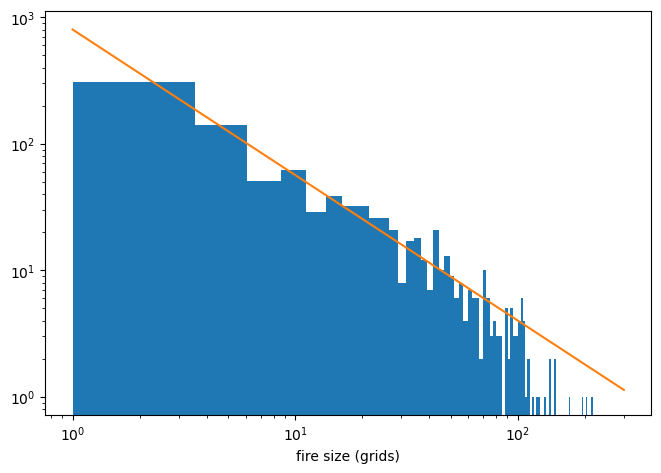

In [45]:
clf()
hist(firesizes[:], 100)
plot([1, 300], 800 .*[1, 300].^-1.15) # f^-1
yscale("log"); xscale("log")
xlabel("fire size (grids)")
gcf()

The fire frequency model for cells is
$$
    F = F_0 \exp(T_\mathrm{fire}/\tau_f)
$$
where $\tau_f = 988$ days and $T_\mathrm{fire}$ is the repeat interval between fires.

In [54]:
# 3D parameters
nd = 3 # dimensions
nx = 100

ntyear = 10 # growing-burning season
ntmature = ntyear * 10   # 10 years to maturity
ntignite = ntyear * 100 # lightning ignites each grid every 100 years
p_grow = 1/ntmature
p_ignite = 1/ntignite

# initialize
Random.seed!(42)

tree = falses(fill(nx, nd)...) # initialize array
sz = size(tree)
C = CartesianIndices(tree)
fire = falses(sz)

# diagnostics count days
# continuously incrementing, reset by events
sincetree = zeros(Int64, sz)
sincefire = zeros(Int64, sz)

# single step
step!(fire, tree, sincefire, sincetree)
any(fire)

false

In [55]:
# big run
nyear = 100
ndays = nyear * ntyear

for i in 1:ndays
    step!(fire, tree, sincefire, sincetree)
end

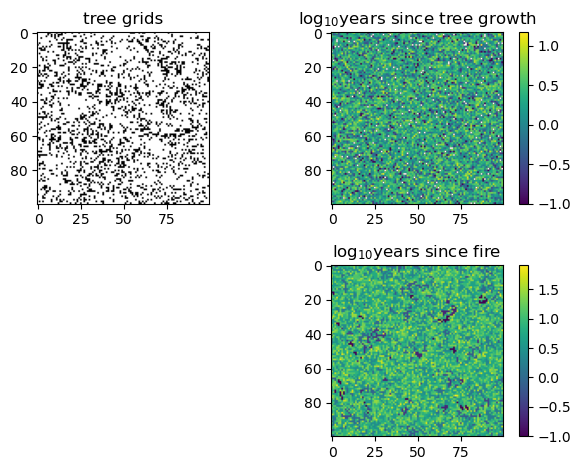

In [56]:
clf()
subplot(2,2,1)
imshow(tree[1,:,:], cmap=PyPlot.cm.Greys)
title("tree grids")

subplot(2,2,2)
imshow(log10.(sincetree[1,:,:]/ntyear)); colorbar()
title("log\$_{10}\$years since tree growth")

subplot(2,2,4)
imshow(log10.(sincefire[1,:,:]/ntyear)); colorbar()
title("log\$_{10}\$years since fire")
tight_layout()
gcf()

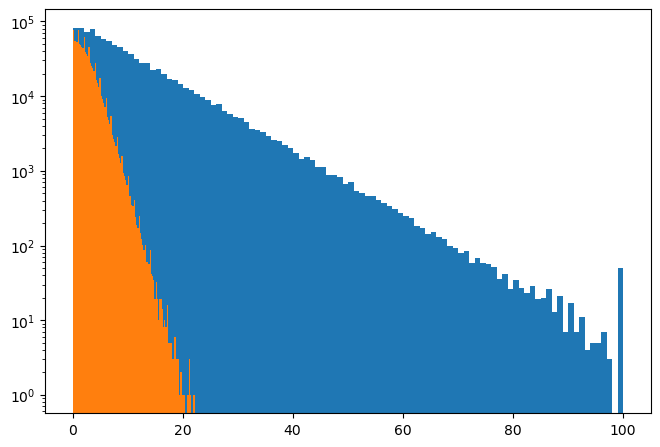

In [57]:
clf()
hist(sincefire[:]/ntyear, 100)
hist(sincetree[:]/ntyear, 100)
# plot([0, 8000], [5e3, 1.5])
# plot(0:100:8000, 5e3*exp.(-(0:100:8000)./988))
yscale("log")
gcf()